## Title: Predictive Modeling of Undergraduate Student Persistence: A Study on Dropout and Academic Success

## Introduction

For our project we have decided to analyse the dataset titled "Predict Student's Dropout and Academic Success". The dataset is created from data collected by higher education institutes (acquired from several disjoint databases) related to students enrolled in different undergraduate degrees, such as agronomy, design, education, nursing, journalism, management, social service, and technologies.

Furthermore, the dataset includes information known at the time of the student's enrollment (academic path, demographics, and social-economic factors) and the students' academic performance at the end of the first and second semesters.

The research question we would like to answer is a classification one where we create a model that allows us to predict whether a student will graduate or drop out of a higher education institute based on their high school grade average and the admission grade of the higher education institute they chose to attend. The admission grade of a university is the average grade required to be admitted to the school. The predictor variable "Target" is a categorical variable that contains 3 categories: dropout, enrolled and graduate. The categories relevant to our analysis are dropout and graduate.

The column titled previous qualification (grade) is a continous column with numbers [0, 200] that represents the student's grade at their previous qualification (whether it be highschool or during their bachelor's degree). The column titled admission grade is also a continuous column with numbers [0, 200] representing the grade set for entry to the institution.

dataset: https://archive.ics.uci.edu/dataset/697/predict+students+dropout+and+academic+success?fbclid=IwAR3ffegYP7CAXRy-izSVKVpd0-vHXf-t4c61G4zQogzcFzUUXAR2hQD1uM0

## Methods & Results

In [1]:
#Run this cell to attach libraries
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)
library(RColorBrewer)

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_co

In [2]:
install.packages("themis")
library(themis)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [3]:
#download data from web
url <- "https://raw.githubusercontent.com/jternier/Test/main/data.csv" 

download.file(url, "data/data2.csv")

__Loading the data__

The first step in the entire process involves loading the data.

In [4]:
data <- read_delim(file = "data/data2.csv", delim = ";") #Load the data into R. File is semi-colon separated so use read_delim function
head(data)

Rows: 4424 Columns: 37
── Column specification ────────────────────────────────────────────────────────
Delimiter: ";"
chr  (1): Target
dbl (36): Marital_status, Application_mode, Application_order, Course, Dayti...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Marital_status,Application_mode,Application_order,Course,Daytime/evening attendance,Previous_qualification,Previous_qualification_grade,Nacionality,Mother_qualification,Father_qualification,⋯,Curricular_units_2nd_sem_(credited),Curricular_units_2nd_sem_(enrolled),Curricular_units_2nd_sem_(evaluations),Curricular_units_2nd_sem_(approved),Curricular_units_2nd_sem_(grade),Curricular_units_2nd_sem_(without evaluations),Unemployment_rate,Inflation_rate,GDP,Target
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,17,5,171,1,1,122.0,1,19,12,⋯,0,0,0,0,0.00000,0,10.8,1.4,1.74,Dropout
1,15,1,9254,1,1,160.0,1,1,3,⋯,0,6,6,6,13.66667,0,13.9,-0.3,0.79,Graduate
1,1,5,9070,1,1,122.0,1,37,37,⋯,0,6,0,0,0.00000,0,10.8,1.4,1.74,Dropout
1,17,2,9773,1,1,122.0,1,38,37,⋯,0,6,10,5,12.40000,0,9.4,-0.8,-3.12,Graduate
2,39,1,8014,0,1,100.0,1,37,38,⋯,0,6,6,6,13.00000,0,13.9,-0.3,0.79,Graduate
2,39,1,9991,0,19,133.1,1,37,37,⋯,0,5,17,5,11.50000,5,16.2,0.3,-0.92,Graduate


__Tidying the data__

After which, we have to tidy the data so that it is in a format that is necessary to peform the analysis.

To tidy the data set, we have decided to implement the following steps:\
__Step 1:__ Select only the columns we want to use in our model (predictor variables + predictor class)\
__Step 2:__ Filter the previous qualifications column so we are only examining students being admitted who have only completed high school\
__Step 3:__ Filter the predictor class Target to have only two categories "Graduate and Dropout" as we only want to consider the two classes and predict whether a student will drop out or graduate\
__Step 4:__ Transform our "Target" column into a factor as it is our predictor class\
__Step 5:__ Check whether we have a sufficient amount of observations that meet our criteria

In [5]:
tidy_data <- data|>
select(Previous_qualification, Previous_qualification_grade, Admission_grade, Target, GDP, Inflation_rate, Unemployment_rate, Gender) |> # select our columns of interest
filter(Previous_qualification == 1) |> #We only want to examine observations whose previous education is completed secondary education
filter(Target == "Graduate" | Target == "Dropout") |> #We only want to examine the binary of dropout vs graduate (not students currently enrolled)
mutate(Target = as_factor(Target)) #We want our classification variable to be a factor as there's a limited amount of categories
head(tidy_data)
nrow(tidy_data) #Check we still have a sufficient amount of observations that meet our criteria

Previous_qualification,Previous_qualification_grade,Admission_grade,Target,GDP,Inflation_rate,Unemployment_rate,Gender
<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
1,122,127.3,Dropout,1.74,1.4,10.8,1
1,160,142.5,Graduate,0.79,-0.3,13.9,1
1,122,124.8,Dropout,1.74,1.4,10.8,1
1,122,119.6,Graduate,-3.12,-0.8,9.4,0
1,100,141.5,Graduate,0.79,-0.3,13.9,0
1,142,128.4,Graduate,-4.06,2.8,15.5,0


[1] 3019

__Creating a dataset__

In [6]:
#Split the data into training and testing. 75% for training and 25% for testing.
# Because we are classifying target, use that as strata
# Set seed so analysis is reproducible
set.seed(2004)

data_split <- initial_split(tidy_data, prop = 0.75, strata = Target) 
dropout_training <- training(data_split) #name training and testing data sets
dropout_testing <- testing(data_split)

__Graphing__

Here we perform a summary of the data set that is relevant for exploratory data analysis related to the planned analysis. We do this by creating a visualization of the relevant exploratory variables.

In [7]:
mean_admission_grade <- dropout_training |>
select(Target, Admission_grade) |>
group_by(Target) |>
summarize(grade = mean(Admission_grade))
mean_admission_grade

mean_qualification_grade <- dropout_training |>
select(Target, Previous_qualification_grade) |>
group_by(Target) |>
summarize(grade = mean(Previous_qualification_grade))
mean_qualification_grade

Target,grade
<fct>,<dbl>
Dropout,124.5490
Graduate,127.8052


Target,grade
<fct>,<dbl>
Dropout,130.7624
Graduate,133.7166


Target,count
<fct>,<int>
Dropout,808
Graduate,1455


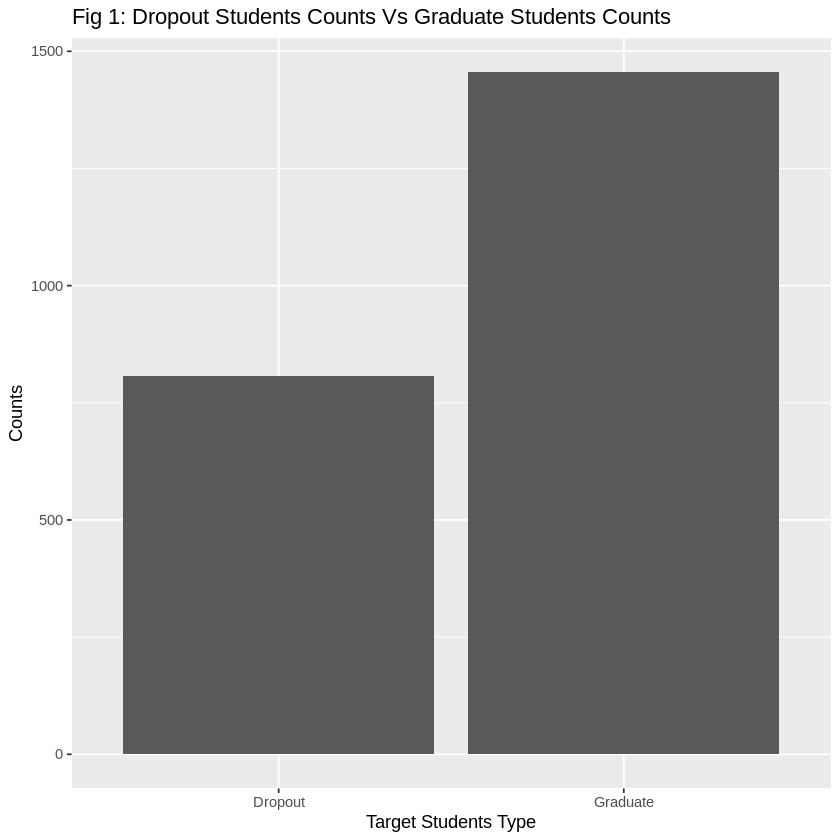

In [8]:
target_count_data <- dropout_training |>
group_by(Target) |>
summarise(count = n())
target_count_data

target_count_graph <- target_count_data |>
ggplot(aes(x = Target, y = count)) +
geom_bar(stat = "identity")+
labs(x = "Target Students Type", y = "Counts") +
ggtitle("Fig 1: Dropout Students Counts Vs Graduate Students Counts ")
target_count_graph 

The bar graph above, titled "Droppout Students Vs Graduate Students Counts" illustrates the split of the dataset between the number of students who dropped out and who graduated. Based on the graph, it is evident that there is a disproportionately high number of students who graduated from a higher secondary instituition. Therefore, when we are analysing our data, we may have to conduct oversampling to ensure that the numbers for students who graduated and students who dropped out are comparable. This will help ensure that the analysis is unbiased and the results are more reliable.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


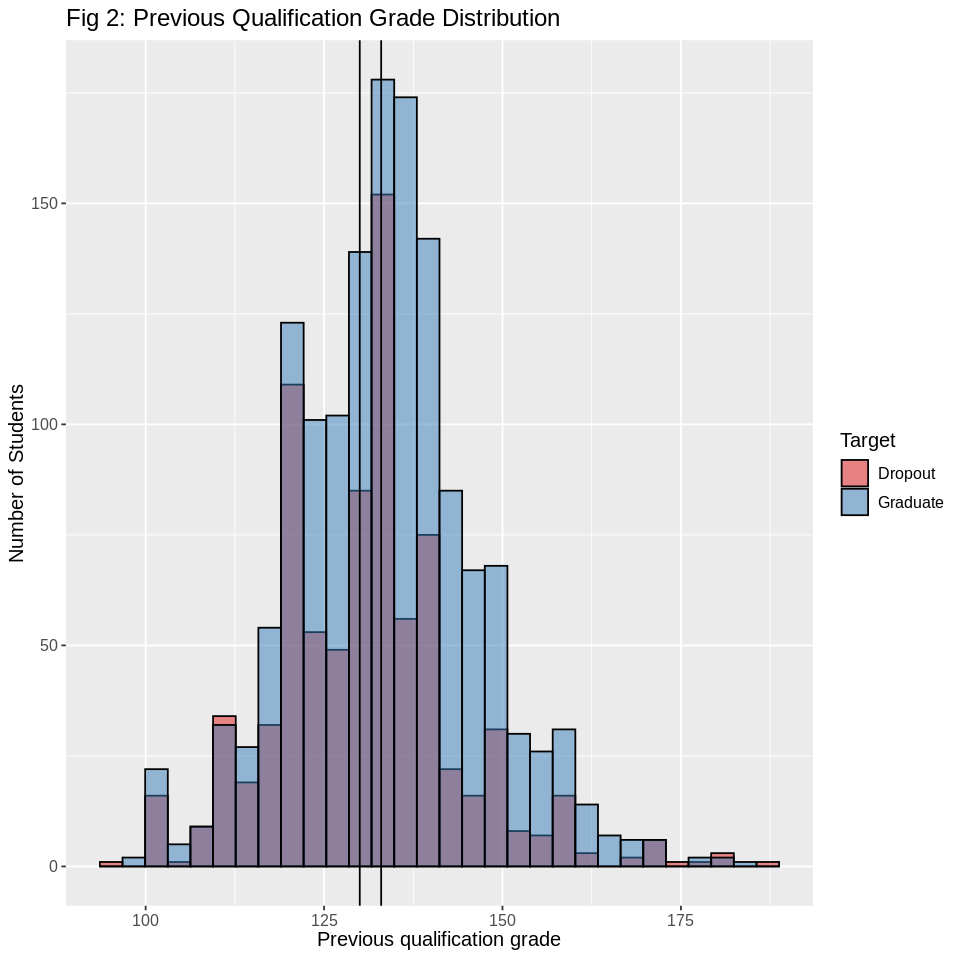

In [9]:
options(repr.plot.width = 8, repr.plot.height = 8)
grade_plot <- dropout_training |>
ggplot(aes(x = Previous_qualification_grade, fill = Target)) +
geom_histogram(color = 'black', alpha = 0.5, position = "identity") +
geom_vline(xintercept = 130 ) +
geom_vline(xintercept = 133 ) +
labs( x = "Previous qualification grade", y = "Number of Students", fill = "Target") +
scale_fill_brewer(palette = 'Set1') +
theme(text = element_text(size = 12))+
ggtitle("Fig 2: Previous Qualification Grade Distribution")
grade_plot

The histogram titled "Previous Qualification Grade Distribution" showcases the distribution of the previous grade acheieved by the high school student before they entered the higher education instituition. Furthemore, this graph helps us visualise the distribution and gives us an overview of the performance of the students we are analysing. The data is split into two colours that overlap each other and represent the two catergories of students that are drop out and graduate. It helps us directly compare the distribution of the two.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


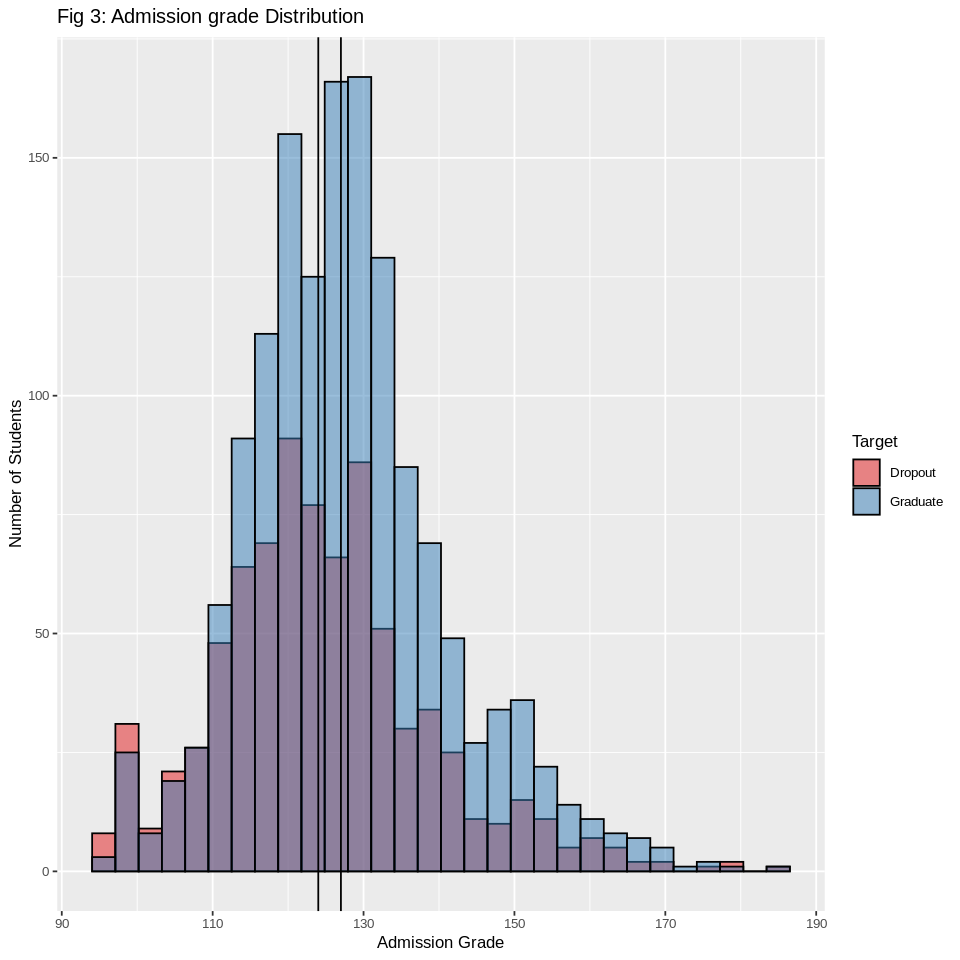

In [10]:
options(repr.plot.width = 8, repr.plot.height = 8)
grade_plot <- dropout_training |>
ggplot(aes(x = Admission_grade, fill = Target)) +
geom_histogram(color = 'Black', alpha = 0.5, position = "identity") +
geom_vline(xintercept = 124) +
geom_vline(xintercept = 127) +
labs( x = "Admission Grade", y = "Number of Students", fill = "Target") + 
scale_fill_brewer(palette = 'Set1') +
theme(text = element_text(size = 10)) +
ggtitle("Fig 3: Admission grade Distribution")
grade_plot

The histogram titled "Admission Grade Distribtution" serves a similar purpose to that earlier graph, except it visualises the distribution of the average admission grade and the number of students who selected schools with that speicific admission grade. Once again, the students are split into dropout and graduated catergories by colours to differentiate and compare their admission grade distributions.

The two histograms aid in illustrating the distributions of the two predictor variables we plan to use for our classification analysis to answer the research question. It works as a guideline to ensure that our analysis isn't unbiased and that our results are reliable.

__GDP/Target Student__

GDP,Target
<dbl>,<fct>
1.74,Dropout
1.74,Dropout
-4.06,Dropout
⋮,⋮
-4.06,Graduate
-3.12,Graduate
-1.70,Graduate


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


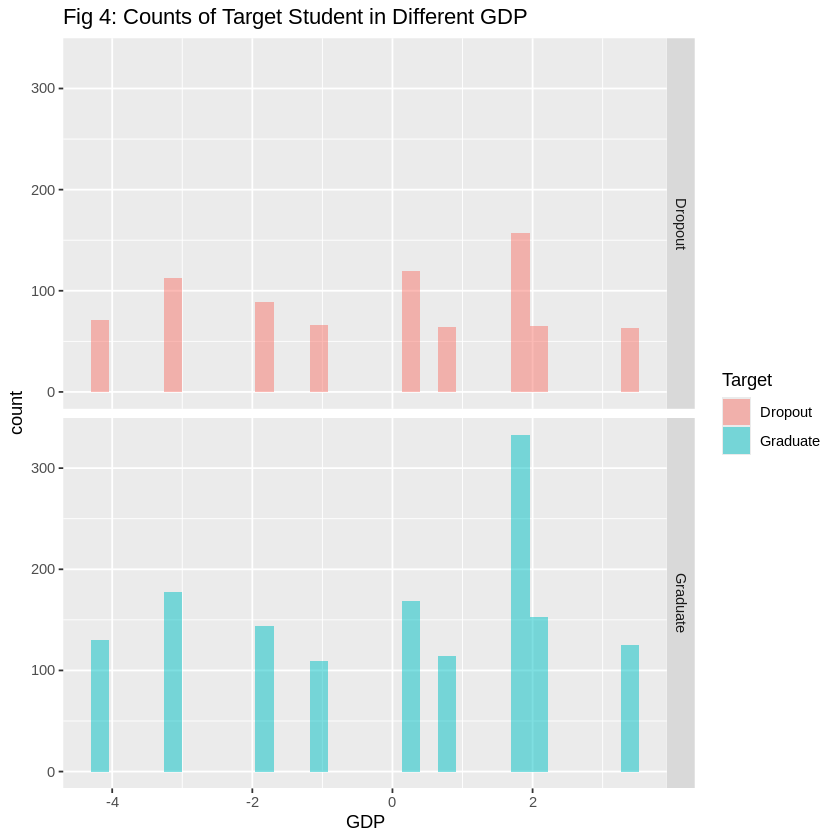

In [11]:
target_econ_data <- dropout_training |>
select(GDP,Target) |>
group_by(Target)
target_econ_data

options(repr.plot.width = 7, repr.plot.height = 7)
econ1_plot <- target_econ_data |>
ggplot(aes(x = GDP, fill = Target)) +
geom_histogram(alpha = 0.5) +
labs(x = 'GDP', y = 'count', fill = 'Target', title = 'Fig 4: Counts of Target Student in Different GDP') +
facet_grid(rows = vars(Target)) 
econ1_plot

As you can see in the histograms above, the distribution of students who graduated or dropped out with GDP is varied. 

For the graduating students, the number of students hovers between the range of 100-200 regardless of the state of the GDP, whether it is a negative number thus implying that the economy is in a recession or that it is a positive number thus implying that the economy is growing. The only exception is at the 2 mark, where the number of students shoots up to over 300. 

Similarly, for dropout students, the pattern is the same. Across the avrious states of the economu, the number of students dropping out hovers between 50-100, with the exception of at 2 where the count crosses to over 150. 

These graphs illustrate that GDP would not act as a good predictor variable as there seems to be no correlation or causation between this and the number of students graduating and dropping out.

__Inflation/Target Student__

Inflation_rate,Target
<dbl>,<fct>
1.4,Dropout
1.4,Dropout
2.8,Dropout
⋮,⋮
2.8,Graduate
-0.8,Graduate
3.7,Graduate


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


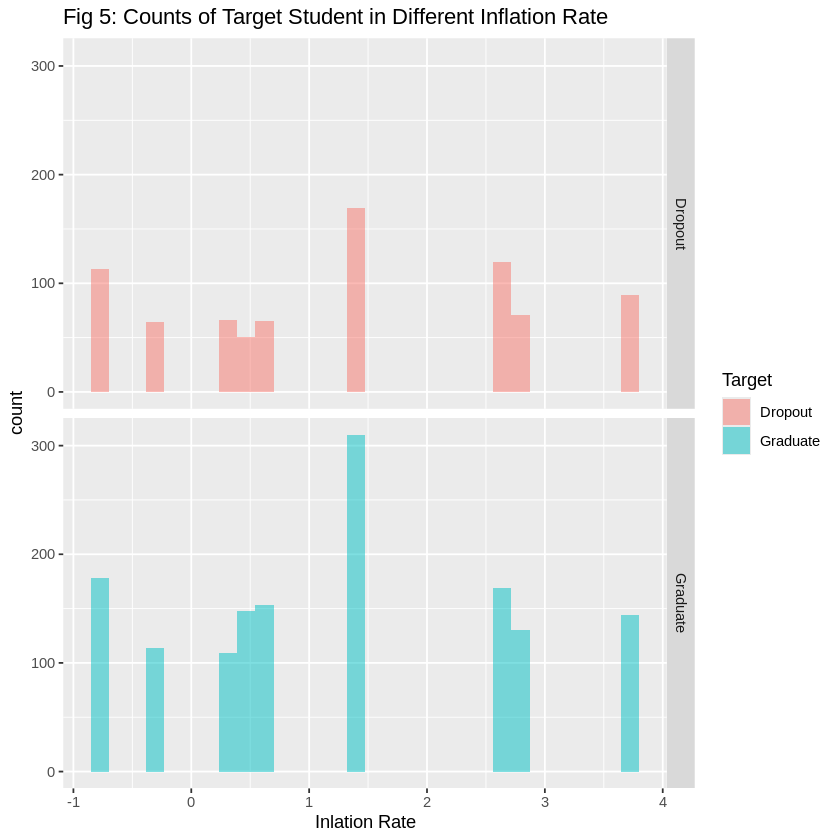

In [12]:
target_inflation_data <- dropout_training |>
select(Inflation_rate, Target) |>
group_by(Target)
target_inflation_data

inflation_plot <- target_inflation_data |>
ggplot(aes(x =Inflation_rate, fill = Target)) +
geom_histogram(alpha = 0.5) +
labs(x = 'Inlation Rate', y = 'count', fill = 'Target', title = 'Fig 5: Counts of Target Student in Different Inflation Rate') +
facet_grid(rows = vars(Target)) 
inflation_plot

Again the histograms above show that the distribution of students graduating or dropping out is varied across the different inflation rates.

For students dropping out, the count of students hovers in the range of 50 to 100 across the different inflation rates. There is an exception at the estimated inflation rate of around 1.5, where the number of students dropping out exceeds 150.

Similarly, for students graduating, the pattern remains that the count of students hovers in a slightly wider range of 100-180. The exception is at the inflation rate of around 1.5 where the number surpasses 300. 

Therefore, these histograms demonstrate that inflation rate would not be a good predictor variable as the distribution of students graduating and dropping out is similar regardless of the inflation rate.

__Unemployment/Target Student__

Unemployment_rate,Target
<dbl>,<fct>
10.8,Dropout
10.8,Dropout
15.5,Dropout
⋮,⋮
15.5,Graduate
9.4,Graduate
12.7,Graduate


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


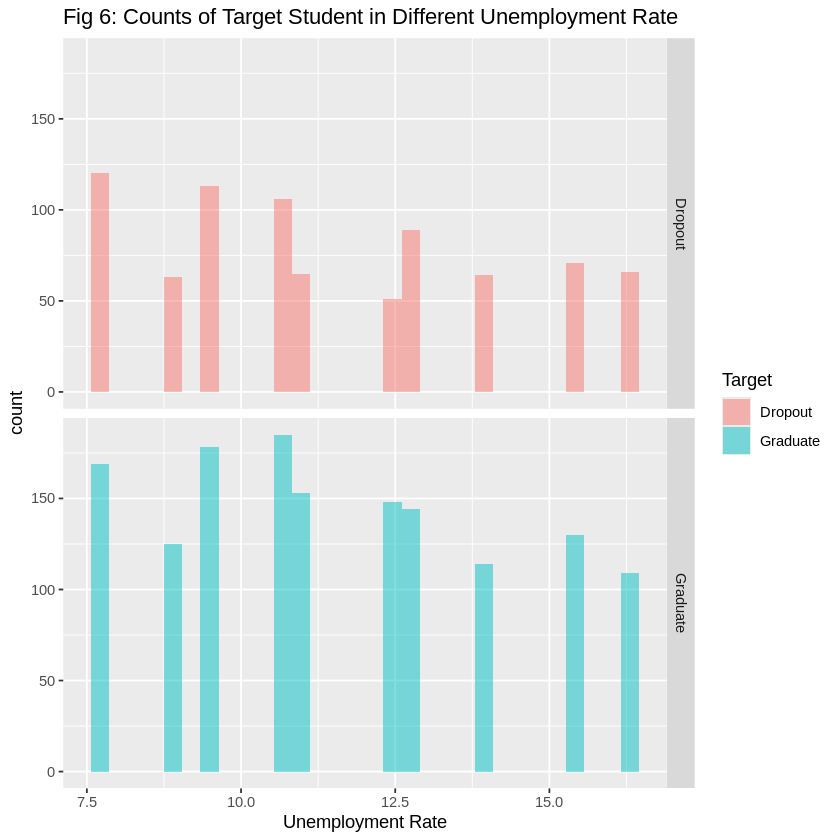

In [13]:
target_Unemployment_data <- dropout_training |>
select(Unemployment_rate, Target) |>
group_by(Target)
target_Unemployment_data

#Unemployment_plot <- target_Unemployment_data |>
#ggplot(aes(x = Unemployment_rate, y = Admission_grade, colour = Target)) +
#geom_point(alpha = 0.5) +
#labs(x = 'Unemployment Rate of Target Students', y = 'Admission Grade of Target Students', fill = 'Target', title = 'Fig 6: Umemployment rate based on Target Student')
#Unemployment_plot
Unemployment_plot <- target_Unemployment_data |>
ggplot(aes(x = Unemployment_rate, fill = Target)) +
geom_histogram(alpha = 0.5) +
labs(x = 'Unemployment Rate', y = 'count', fill = 'Target', title = 'Fig 6: Counts of Target Student in Different Unemployment Rate') +
facet_grid(rows = vars(Target)) 
Unemployment_plot

The histograms above illustrate the distribution of the drop outs and graduates respectively with the unemployment rate in the economy during that time. 

For the dropouts with the unemployment rate, there seems to be a weak negative correlation of the number of dropouts with the unemployment rate. When the unemployment rate is the lowest at 7.5%, the number of students who dropped out peaked at around 125. Furthermore, as the unemployment rate increases the number of students who dropped out reduces, with the lowest number of approx 75 at the highest unemployment rate at approx 16.25%. However, there seems to be a lot of variation as there is not a smooth decrease in the count of dropouts as the unemployment rate rises.

For graduates, the distribution is different. The number of graduates seems to peak around 10% unemployment rate. However, there is even more variation than for the dropouts so it is hard to conclude that the distribution here is impacted by the unemployment rate.

In conclusion, unemployment rate can’t be used as a reliable predictor variable. This is because it impacts graduates and dropouts differently. At best, the unemployment rate may slightly influence the number of students who drop out and at worst, there is no impact on either the number of graduates or the number of dropouts.


The 3 graphs above that plotted the various macroeconomic indicators (GDP, inflation rate and unemployment rate) illustrate how these variables wouldn't be good predcitor variables as they impact students of both categories (graduates and drop outs) similarly.

In [22]:
target_male_data <- dropout_training |>
select(Gender,Target) |>
group_by(Target) |>
filter(Gender == 1)
target_male_data

#plot
male_male_plot <- target_male_data |>
ggplot(aes(x = Target, y = Target)) +
geom_bar(stat = "identity") +
labs(x = "Target Students", y = "Male Counts") +
ggtitle("Fig 7: Male Target Student")
male_male_plot

target_female_data <- dropout_training |>
select(Gender,Target) |>
group_by(Target) |>
filter(Gender == 0)
target_female_data

#plot
female_plot <- target_female_data |>
ggplot(aes(x = Target, y = Target)) +
geom_bar(stat = "identity") +
labs(x = "Target Students", y = "Female Counts") +
ggtitle("Fig 8: Female Target Student")
female_plot

ERROR: [1m[33mError[39m in `select()`:[22m
[33m![39m Can't subset columns that don't exist.
[31m✖[39m Column `Gender` doesn't exist.


The bar graph above, titled "Droppout Students Vs Graduate Students Counts" illustrates the split of the dataset between the number of students who dropped out and who graduated. Based on the graph, it is evident that there is a disproportionately high number of students who graduated from a higher secondary instituition. Therefore, when we are analysing our data, we may have to conduct oversampling to ensure that the numbers for students who graduated and students who dropped out are comparable. This will help ensure that the analysis is unbiased and the results are more reliable.

__Classification__

Here we start the analysis of the data set by figuring out the optimal value of k neighbours to implement a classification model to answer our predictive question. As mentioned earlier, we are going to use two predictor variables: admission grade and previous qualification grade of only students who graduated high school to answer our question.

To find the ideal number of k neighbours we are going to calculate accuracy and plot that across multiple k values to find the k value that yields the highest accuracy. Accuracy is a measure of how "good or bad" the k is as predicting the target variable of the category of our student (graduate or drop out). 

Within the recipe we added a step up sample function which will ensure there is an even distribution of dropouts to graduates so our classifier is not biased. We also scaled and centered our predictors to ensure they are weighted evenly. We tested K-values from 0-140, however due to the lengthy time it took to run the code, we cut the demonstrated K-values down to 90-140 so the best value can still be seen and the code doesn't take as long to run. We ran a 5-fold cross validation to ensure the validity of our results



── Recipe ──────────────────────────────────────────────────────────────────────



── Inputs 

Number of variables by role

outcome:   1
predictor: 2



── Training information 

Training data contained 2263 data points and no incomplete rows.



── Operations 

• Up-sampling based on: Target | Trained

• Scaling for: Previous_qualification_grade, Admission_grade | Trained

• Centering for: Previous_qualification_grade, Admission_grade | Trained



neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
90,accuracy,binary,0.5828440,5,0.01249257,Preprocessor1_Model01
95,accuracy,binary,0.5881420,5,0.01428229,Preprocessor1_Model02
100,accuracy,binary,0.5943377,5,0.01398910,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
130,accuracy,binary,0.5934546,5,0.011465245,Preprocessor1_Model09
135,accuracy,binary,0.5863818,5,0.008639264,Preprocessor1_Model10
140,accuracy,binary,0.5846090,5,0.009340257,Preprocessor1_Model11


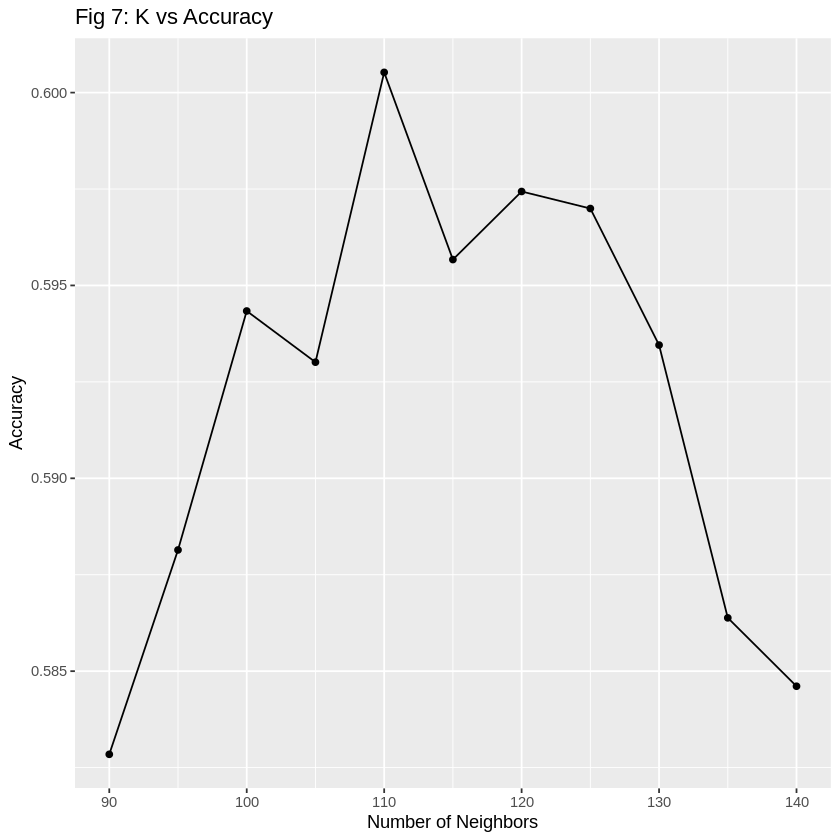

In [15]:
set.seed(2000)

# Create Recipe
dropout_recipe <- recipe(Target ~ Previous_qualification_grade + Admission_grade, data = dropout_training) |>
step_upsample(Target, over_ratio = 1, skip = TRUE) |> #add oversampling to ensure the ration of graduates:dropouts = 1
step_scale(all_predictors()) |> #Center and scale predictors so they are evenly weighted
step_center(all_predictors()) |>
prep()

dropout_recipe

#Specify folds for cross validation
dropout_vfold <- vfold_cv(dropout_training, v = 5, strata = Target)

#Specify K-values to try
gridvals <- tibble("neighbors" = seq(from = 90, to = 140, by = 5))

#Add specification
dropout_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
set_engine("kknn") |>
set_mode("classification")

dropout_workflow <- workflow() |>
add_recipe(dropout_recipe) |>
add_model(dropout_spec) |>
tune_grid(resamples = dropout_vfold, grid = gridvals) |>
collect_metrics() |>
filter(.metric == "accuracy")

dropout_workflow

cross_val_plot <- dropout_workflow |>
ggplot(aes(x = neighbors, y = mean)) + 
geom_point() +
geom_line() + 
xlab("Number of Neighbors") + 
ylab("Accuracy") +
ggtitle("Fig 7: K vs Accuracy")

cross_val_plot

Looking at Fig. 7 you can see that accuracy is highest when k = 110, therefore that is the K-value that we will use in our predictive analysis.

In [16]:
test_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 110) |>
set_engine("kknn") |>
set_mode("classification")

test_fit <- workflow() |>
add_recipe(dropout_recipe) |>
add_model(test_spec) |>
fit(data = dropout_training)
test_fit

dropout_test_predictions <- predict(test_fit, dropout_testing) |>
bind_cols(dropout_testing)
dropout_test_predictions

dropout_mat <- dropout_test_predictions |>
conf_mat(truth = Target, estimate = .pred_class)
dropout_mat

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
3 Recipe Steps

• step_upsample()
• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(110,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.4006873
Best kernel: rectangular
Best k: 110

.pred_class,Previous_qualification,Previous_qualification_grade,Admission_grade,Target,GDP,Inflation_rate,Unemployment_rate,Gender
<fct>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
Graduate,1,160,142.5,Graduate,0.79,-0.3,13.9,1
Graduate,1,137,129.3,Graduate,-0.92,0.3,16.2,0
Graduate,1,139,130.6,Graduate,0.79,-0.3,13.9,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Graduate,1,131,121.9,Graduate,2.02,0.6,11.1,0
Dropout,1,100,133.0,Dropout,-1.70,3.7,12.7,1
Graduate,1,120,119.0,Dropout,2.02,0.6,11.1,0


          Truth
Prediction Dropout Graduate
  Dropout      142      174
  Graduate     128      312

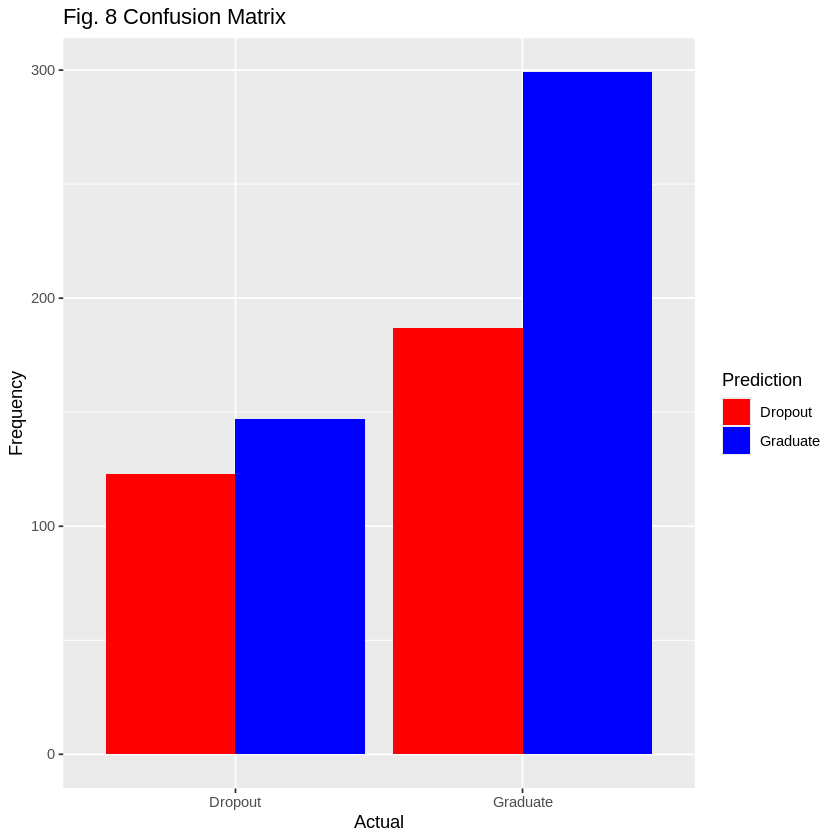

In [17]:
# Confusion Matrix
dropout <- c(123, 147)
graduate <- c(187, 299)

# Create data frame
confusion_df <- data.frame(
  Prediction = c("Dropout", "Graduate", "Dropout", "Graduate"),
  Actual = rep(c("Dropout", "Graduate"), each = 2),
  Frequency = c(dropout, graduate)
)

# Plot
confusion_matrix_plot <- confusion_df |>
ggplot(aes(x = Actual, y = Frequency, fill = Prediction)) +
geom_bar(stat = "identity", position = "dodge") +
labs(title = "Fig. 8 Confusion Matrix", x = "Actual", y = "Frequency") +
scale_fill_manual(values = c("red", "blue"), 
labels = c("Dropout", "Graduate"))
confusion_matrix_plot

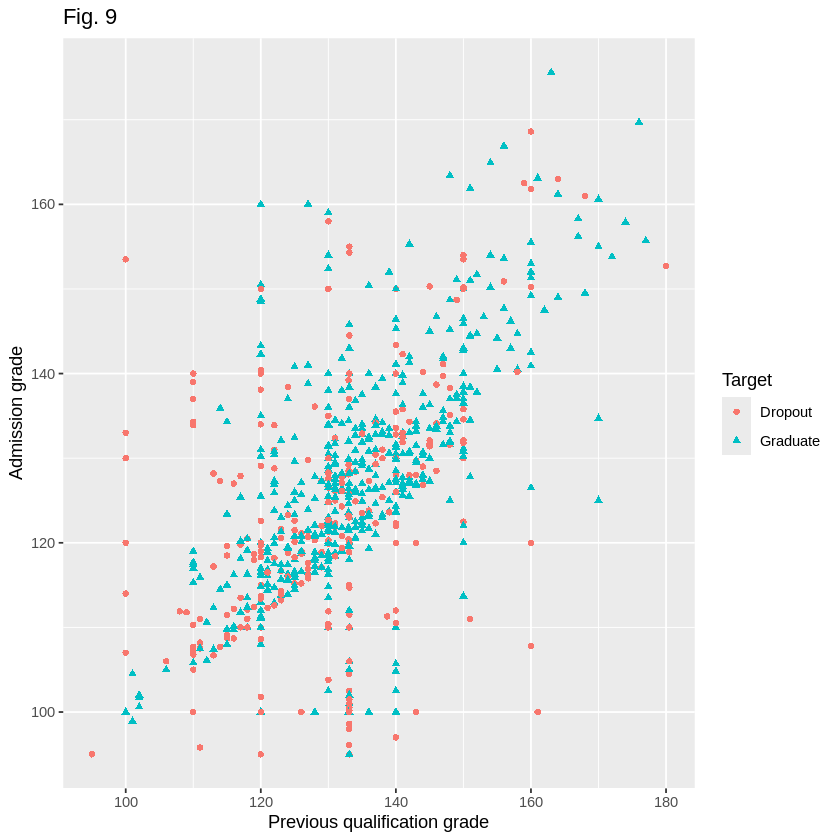

In [18]:
Actual_test_plot <- ggplot(dropout_testing, aes(x = Previous_qualification_grade, y = Admission_grade)) + 
     geom_point(aes(colour = Target, shape = Target)) + 
     labs(x="Previous qualification grade", y="Admission grade", colour="Target", shape="Target") +
    ggtitle("Fig. 9")
Actual_test_plot

## Discussion ##

talking points: 
- bad model...looking at distribution of points in above figure, probably because there's no obvious pattern
- high k-value (110), mention that we have a lot of data points (around 2500) so its not that bad of a k-value
- bad accuracy, our highest k-value had an accuracy of 60% which is really not good and explains why our model is so bad
- add more predictors to improve the classification

__References__

1. Realinho,Valentim, Vieira Martins,Mónica, Machado,Jorge, and Baptista,Luís. (2021). Predict Students' Dropout and Academic Success. UCI Machine Learning Repository. https://doi.org/10.24432/C5MC89.
2. Ensminger, M. E., & Slusarcick, A. L. (1992). Paths to High School Graduation or Dropout: A Longitudinal Study of a First-Grade Cohort. Sociology of Education, 65(2), 95113. https://doi.org/10.2307/2112677
3. Veiga, N. (2022). Interactive tools for first-semester undergraduate chemistry course in uruguay: Student choices and impact on student performance and dropout. Journal of Chemical Education, 99(2), 851-863. https://doi.org/10.1021/acs.jchemed.1c00750